In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
import matplotlib.pyplot as plt

import pycaret
from pycaret.classification import ClassificationExperiment
from pycaret.datasets import get_data

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

from ydata_profiling import ProfileReport

from utils import *

In [2]:
full_data = get_data('../data/heart_disease_uci/heart_disease_uci')

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
full_data.shape

(920, 16)

In [23]:
data, _ = train_test_split(full_data, train_size=200)

In [5]:
profile = ProfileReport(data, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

let's drop `id` and `dataset` columns since model wouldn't have access to this meta-info when inferencing

also change boolean type columns to string (pycaret really doesn't like bools for some reason)

In [5]:
data = data.drop(columns=['id', 'dataset'])
data['fbs'] = data['fbs'].astype('Int64')
data['exang'] = data['exang'].astype('Int64')

full_data = full_data.drop(columns=['id', 'dataset'])
full_data['fbs'] = full_data['fbs'].astype('Int64')
full_data['exang'] = full_data['exang'].astype('Int64')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 458 to 903
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       200 non-null    int64  
 1   sex       200 non-null    object 
 2   cp        200 non-null    object 
 3   trestbps  189 non-null    float64
 4   chol      198 non-null    float64
 5   fbs       178 non-null    Int64  
 6   restecg   200 non-null    object 
 7   thalch    189 non-null    float64
 8   exang     189 non-null    Int64  
 9   oldpeak   186 non-null    float64
 10  slope     134 non-null    object 
 11  ca        72 non-null     float64
 12  thal      97 non-null     object 
 13  num       200 non-null    int64  
dtypes: Int64(2), float64(5), int64(2), object(5)
memory usage: 23.8+ KB


In [7]:
n_classes = data['num'].unique().size

In [20]:
n_classes

5

---
### CatBoostEncoder

In [24]:
exp = ClassificationExperiment()
exp.setup(
    data,
    target='num',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

,Description,Value
0,Session id,42
1,Target,num
2,Target type,Multiclass
3,Original data shape,"(200, 14)"
4,Transformed data shape,"(200, 14)"
5,Transformed train set shape,"(140, 14)"
6,Transformed test set shape,"(60, 14)"
7,Numeric features,8
8,Categorical features,5
9,Rows with missing values,69.0%


In [25]:
best = exp.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5571,0.3984,0.5571,0.4888,0.5063,0.3124,0.3319,0.1120
knn,K Neighbors Classifier,0.5429,0.3803,0.5429,0.4506,0.4834,0.2747,0.2908,0.0500
catboost,CatBoost Classifier,0.5071,0.3956,0.5071,0.4874,0.4870,0.2565,0.2664,1.5590
lightgbm,Light Gradient Boosting Machine,0.4929,0.3694,0.4929,0.4847,0.4737,0.2438,0.2505,0.0880
ridge,Ridge Classifier,0.4857,0.0000,0.4857,0.4326,0.4496,0.2230,0.2322,0.0490
dt,Decision Tree Classifier,0.4714,0.3033,0.4714,0.4643,0.4392,0.1958,0.2104,0.0490
xgboost,Extreme Gradient Boosting,0.4714,0.3765,0.4714,0.4455,0.4429,0.2018,0.2128,0.0960
rf,Random Forest Classifier,0.4643,0.3868,0.4643,0.3674,0.3979,0.1456,0.1638,0.1130
lr,Logistic Regression,0.4571,0.0000,0.4571,0.4766,0.4469,0.2224,0.2329,0.0500
svm,SVM - Linear Kernel,0.4429,0.0000,0.4429,0.4401,0.4336,0.1905,0.1976,0.0490


In [26]:
best = exp.create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7143,0.0000,0.7143,0.6786,0.6758,0.5758,0.6085
1,0.4286,0.0000,0.4286,0.3929,0.3894,0.0261,0.0284
2,0.5000,0.0000,0.5000,0.5102,0.4908,0.2794,0.2858
3,0.5714,0.0000,0.5714,0.5333,0.5403,0.3824,0.3972
4,0.6429,0.0000,0.6429,0.5204,0.5649,0.4697,0.5069
5,0.4286,0.7525,0.4286,0.3393,0.3776,0.1318,0.1355
6,0.4286,0.7484,0.4286,0.3571,0.3878,0.1318,0.1355
7,0.6429,0.8723,0.6429,0.5476,0.5782,0.4697,0.4859
8,0.6429,0.7291,0.6429,0.5087,0.5522,0.3458,0.4026


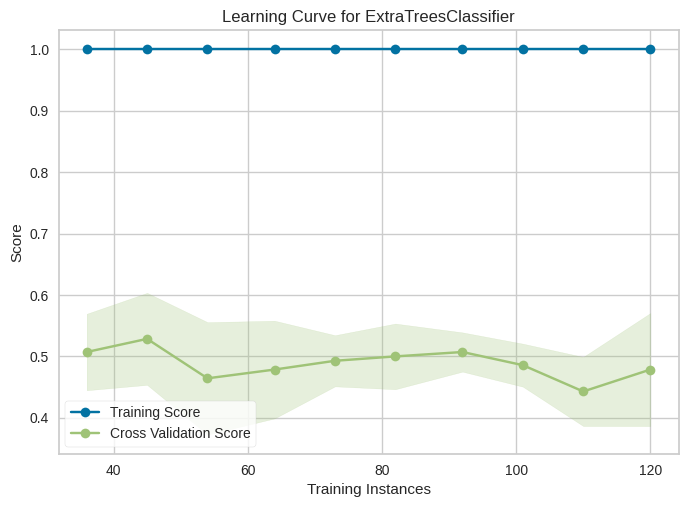

In [12]:
exp.plot_model(best, plot='learning', fold=7)

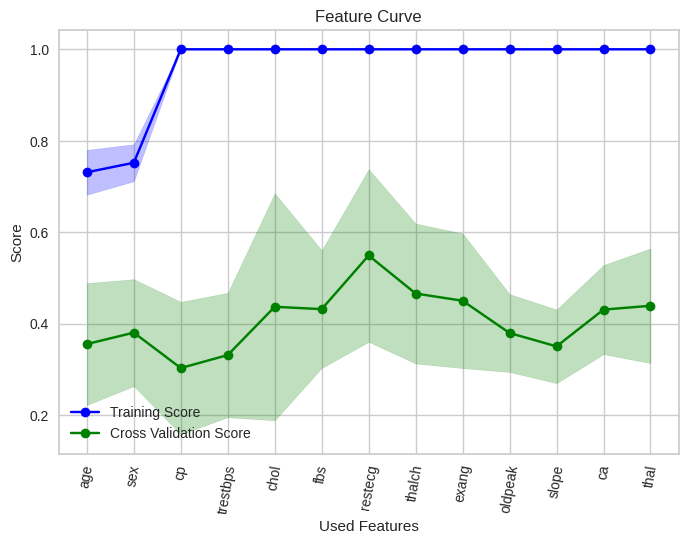

In [13]:
fc = FeatureCurve(best, exp.X_train_transformed, exp.y_train_transformed, features_order=exp.X_train_transformed.columns)
fc.fit(exp.X_train_transformed, exp.y_train_transformed)

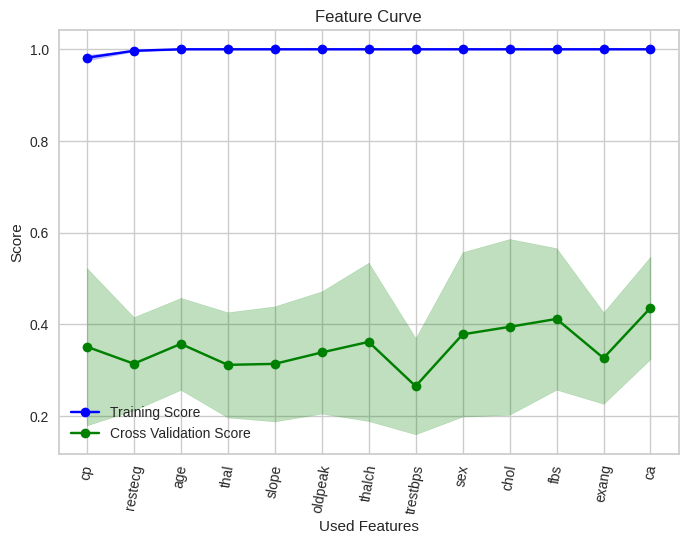

In [14]:
fc = FeatureCurve(best, exp.X_train_transformed, exp.y_train_transformed)
fc.fit(exp.X_train_transformed, exp.y_train_transformed)

CPU times: user 10.7 s, sys: 41.5 ms, total: 10.8 s
Wall time: 10.8 s


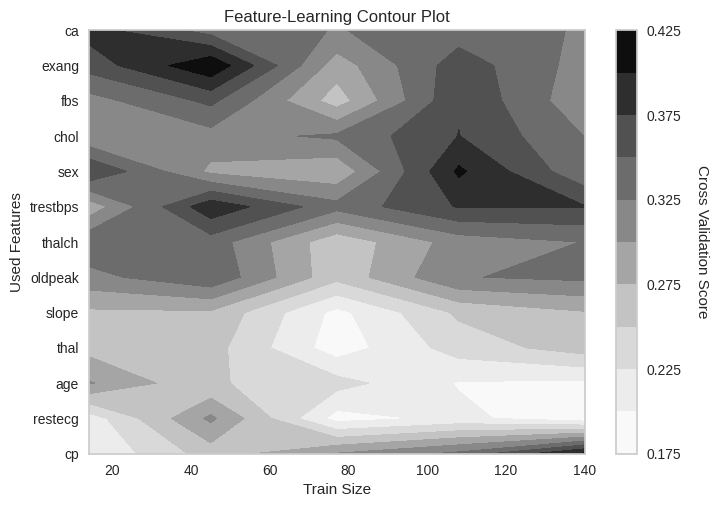

In [15]:
%%time
flc = FeatureLearningCurve(best, exp.X_train_transformed, exp.y_train_transformed, cv=3,
                           features_order=fc.features_order_, scoring=balanced_accuracy_score
)
flc.fit(exp.X_train_transformed, exp.y_train_transformed, exp.X_test_transformed, exp.y_test_transformed)

---
### TabEBM with CatBoostEncoder

In [27]:
from tabebm.TabEBM import TabEBM

In [28]:
tabebm = TabEBM(plotting=False)
augmented_data = tabebm.generate(exp.X_train_transformed.values, exp.y_train_transformed.values, num_samples=500//n_classes)

In [29]:
X_syn = np.concatenate(list(augmented_data.values()))
y_syn = np.concatenate([np.full(len(augmented_data[f"class_{i}"]), i) for i in range(len(augmented_data.keys()))])
X_train_augmented = np.concatenate([exp.X_train_transformed, X_syn])
y_train_augmented = np.concatenate([exp.y_train_transformed, y_syn])

In [30]:
best.fit(exp.X_train_transformed, exp.y_train_transformed)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.3913828689370485

In [31]:
best.fit(X_train_augmented, y_train_augmented)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.33865546218487397

---
### Full data experiement

In [9]:
exp_full = ClassificationExperiment()
exp_full.setup(
    full_data,
    target='num',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

,Description,Value
0,Session id,42
1,Target,num
2,Target type,Multiclass
3,Original data shape,"(920, 14)"
4,Transformed data shape,"(920, 14)"
5,Transformed train set shape,"(644, 14)"
6,Transformed test set shape,"(276, 14)"
7,Numeric features,8
8,Categorical features,5
9,Rows with missing values,67.5%


In [11]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5759,0.0000,0.5759,0.5102,0.5347,0.3491,0.3574,0.0890
rf,Random Forest Classifier,0.5758,0.7947,0.5758,0.5315,0.5418,0.3475,0.3549,0.2930
catboost,CatBoost Classifier,0.5605,0.7914,0.5605,0.5278,0.5336,0.3350,0.3436,4.6650
et,Extra Trees Classifier,0.5604,0.7971,0.5604,0.5077,0.5248,0.3234,0.3311,0.1940
ridge,Ridge Classifier,0.5574,0.0000,0.5574,0.4855,0.4980,0.2948,0.3104,0.0930
knn,K Neighbors Classifier,0.5574,0.7552,0.5574,0.4863,0.5088,0.3088,0.3183,0.0910
lightgbm,Light Gradient Boosting Machine,0.5529,0.7861,0.5529,0.5296,0.5317,0.3312,0.3372,0.3380
gbc,Gradient Boosting Classifier,0.5498,0.0000,0.5498,0.5271,0.5238,0.3243,0.3345,1.0600
xgboost,Extreme Gradient Boosting,0.5327,0.7775,0.5327,0.5097,0.5119,0.3024,0.3086,0.2940
ada,Ada Boost Classifier,0.4752,0.0000,0.4752,0.4676,0.4421,0.2148,0.2280,0.1870


In [12]:
best_full = exp_full.create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6769,0.8494,0.6769,0.6574,0.6572,0.5153,0.5223
1,0.5538,0.7525,0.5538,0.4751,0.5089,0.3098,0.3168
2,0.6000,0.8251,0.6000,0.5545,0.5622,0.3752,0.3884
3,0.6308,0.8205,0.6308,0.6308,0.6149,0.4522,0.4605
4,0.5156,0.7781,0.5156,0.4770,0.4942,0.2668,0.2684
5,0.5000,0.7588,0.5000,0.4627,0.4616,0.2159,0.2218
6,0.6094,0.8007,0.6094,0.5321,0.5493,0.3822,0.3964
7,0.5625,0.8019,0.5625,0.5182,0.5248,0.3186,0.3252
8,0.5469,0.7747,0.5469,0.4967,0.5146,0.3051,0.3108


In [15]:
best_full.fit(exp_full.X_train_transformed, exp_full.y_train_transformed)
balanced_accuracy_score(best_full.predict(exp_full.X_test_transformed), exp_full.y_test_transformed)

0.452138333451932